<a href="https://colab.research.google.com/github/ankesh86/InteractDiffusionSmallData/blob/main/CLIPEMBEDDING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

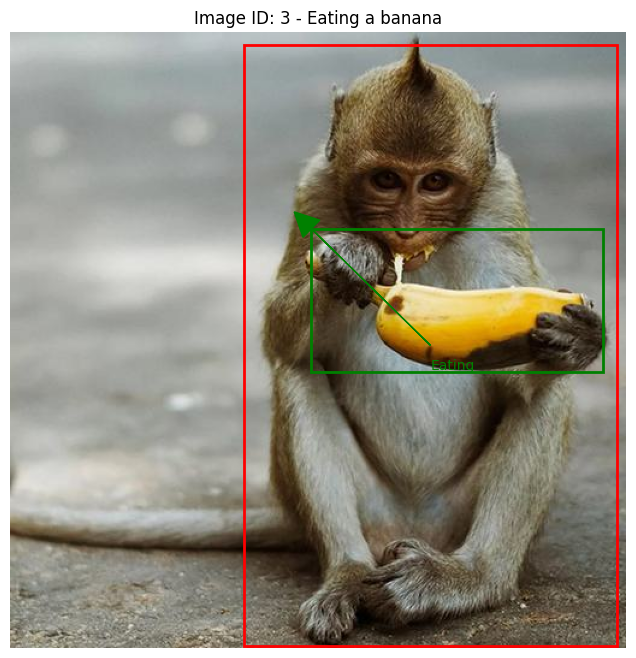

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Example input data
example_input = {
    "img_id": "3",
    "file_name": "img003.jpg",
    "width": 512,
    "height": 512,
    "annotations": [
        {"category_id": 1, "bbox": [194, 10, 310, 500.01], "area": 155003, "iscrowd": 0},
        {"category_id": 2, "bbox": [250, 163, 242, 119], "area": 28798, "iscrowd": 0}
    ],
    "hoi_annotation": [
        {"subject_id": 0, "object_id": 1, "category_id": 1}
    ]
}

# Define interaction and object mappings
interaction_category_mapping = {
    "Eating": 1,
    "Climbing": 2,
    "Drinking": 3,
    "Sitting": 4,
    "Smelling": 5,
    "Swinging": 6,
    "Holding": 7,
    "Carrying": 8,
}
object_id_mapping = {
    "bottle": 1,
    "banana": 2,
    # Add more objects as needed
}

# Load the image
img = Image.open(f"img003.jpg")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Display the image
ax.imshow(img)

# Plot the bounding boxes
for annotation in example_input["annotations"]:
    x, y, w, h = annotation["bbox"]
    category_id = annotation["category_id"]
    if category_id == 1:
        rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor='r', linewidth=2)
    else:
        rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor='g', linewidth=2)
    ax.add_patch(rect)

# Plot the interaction annotations
for hoi_annotation in example_input["hoi_annotation"]:
    subject_id = hoi_annotation["subject_id"]
    object_id = hoi_annotation["object_id"]
    category_id = hoi_annotation["category_id"]
    interaction_type = list(interaction_category_mapping.keys())[category_id - 1]
    object_type = list(object_id_mapping.keys())[object_id]

    # Find the bounding boxes for the subject and object
    try:
        subject_bbox = example_input["annotations"][subject_id]["bbox"]
        object_bbox = example_input["annotations"][object_id]["bbox"]
    except IndexError:
        print(f"Error: Subject or object ID {subject_id} or {object_id} not found in annotations.")
        continue

    # Plot the interaction arrow
    ax.arrow(subject_bbox[0] + subject_bbox[2] / 2,
             subject_bbox[1] + subject_bbox[3] / 2,
             object_bbox[0] - subject_bbox[0] - subject_bbox[2] / 2,
             object_bbox[1] - subject_bbox[1] - subject_bbox[3] / 2,
             head_width=20, head_length=20, fc='g', ec='g')

    ax.text(subject_bbox[0] + subject_bbox[2] / 2,
            subject_bbox[1] + subject_bbox[3] / 2 + 20,
            f"{interaction_type}", color='g', fontsize=10)

ax.set_title(f"Image ID: {example_input['img_id']} - {interaction_type} a {object_type}")
ax.set_axis_off()
plt.show()

In [10]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from torchvision import transforms

# Initialize CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")



In [ ]:
# Define interaction and object mappings
interaction_category_mapping = {
    "Eating": 1,
    "Climbing": 2,
    "Drinking": 3,
    "Sitting": 4,
    "Smelling": 5,
    "Swinging": 6,
    "Holding": 7,
    "Carrying": 8,
}
object_id_mapping = {
    "bottle": 1,
    "banana": 2,
    # Add more objects as needed
}


In [40]:

def crop_image(image, bbox):
    """Crop image using bounding box coordinates."""
    x, y, w, h = bbox
    return image.crop((x, y, x + w, y + h))

def generate_clip_embeddings(image_path, annotations, hoi_annotations):
    # Load the image
    try:
        image = Image.open(image_path).convert("RGB")
    except FileNotFoundError:
        print(f"Image at path {image_path} not found.")
        return {}

    embeddings = {}

    # Extract bounding boxes for subjects (person) and objects
    subjects = [ann for ann in annotations if ann["category_id"] == 1]  # Human subjects
    objects = [ann for ann in annotations if ann["category_id"] == 2]   # Non-human objects

    print("Subjects:", subjects)
    print("Objects:", objects)

    for hoi in hoi_annotations:
        subject_id = hoi["subject_id"]
        obj_id = hoi["object_id"] - 1

        # Debugging output
        print(f"Processing HOI: subject_id={subject_id}, obj_id={obj_id}")
        print(f"Length of subjects: {len(subjects)}, Length of objects: {len(objects)}")

        # Check if indices are out of range
        if subject_id >= len(subjects) or obj_id >= len(objects):
            print("Warning: subject_id or obj_id is out of range.")
            continue

        # Crop the images using bounding boxes
        subj_bbox = subjects[subject_id]["bbox"]
        obj_bbox = objects[obj_id]["bbox"]

        print("Subject BBox:", subj_bbox)
        print("Object BBox:", obj_bbox)

        subj_image = crop_image(image, subj_bbox)
        obj_image = crop_image(image, obj_bbox)

        print("Subject Image size:", subj_image.size)
        print("Object Image size:", obj_image.size)

        # Create the text description based on the interaction
        interaction_category = list(interaction_category_mapping.keys())[hoi["category_id"] - 1]
        object_name = list(object_id_mapping.keys())[obj_id]
        text_description = f"A monkey is {interaction_category} a {object_name}"

        # Process images and text using CLIP processor
        try:
            with torch.no_grad():
                # Process both images together
                inputs = processor(
                    images=[subj_image, obj_image],
                    text=text_description,
                    return_tensors="pt",
                    padding=True
                )

                # Get model outputs
                outputs = model(**inputs)

                # Average the image embeddings (if there are multiple)
                image_embedding = outputs.image_embeds.mean(dim=0).cpu().numpy()
                text_embedding = outputs.text_embeds.squeeze(0).cpu().numpy()

                # Store embeddings
                interaction_key = f"interaction_{hoi['category_id']}"
                embeddings[interaction_key] = {
                    "image_embedding": image_embedding,
                    "text_embedding": text_embedding,
                    "text_description": text_description
                }

                print(f"Successfully processed {interaction_key}")

        except Exception as e:
            print(f"Error processing HOI {hoi['category_id']}: {str(e)}")
            continue

    return embeddings

# Example usage
if __name__ == "__main__":
    input_data = {
        "img_id": "3",
        "file_name": "img003.jpg",
        "width": 512,
        "height": 512,
        "annotations": [
            {"category_id": 1, "bbox": [194, 10, 310, 500.01], "area": 155003, "iscrowd": 0},
            {"category_id": 2, "bbox": [250, 163, 242, 119], "area": 28798, "iscrowd": 0}
        ],
        "hoi_annotation": [
            {"subject_id": 0, "object_id": 1, "category_id": 1}
        ]
    }

    embeddings = generate_clip_embeddings(
        input_data["file_name"],
        input_data["annotations"],
        input_data["hoi_annotation"]
    )

    # Print results
    for key, value in embeddings.items():
        print(f"\n{key}:")
        print(f"Text description: {value['text_description']}")
        print(f"Image embedding shape: {value['image_embedding'].shape}")
        print(f"Text embedding shape: {value['text_embedding'].shape}")

Subjects: [{'category_id': 1, 'bbox': [194, 10, 310, 500.01], 'area': 155003, 'iscrowd': 0}]
Objects: [{'category_id': 2, 'bbox': [250, 163, 242, 119], 'area': 28798, 'iscrowd': 0}]
Processing HOI: subject_id=0, obj_id=0
Length of subjects: 1, Length of objects: 1
Subject BBox: [194, 10, 310, 500.01]
Object BBox: [250, 163, 242, 119]
Subject Image size: (310, 500)
Object Image size: (242, 119)
Successfully processed interaction_1

interaction_1:
Text description: A monkey is Eating a bottle
Image embedding shape: (512,)
Text embedding shape: (512,)
